# Imports

In [2]:
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.drift_detection import ADWIN
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.data import FileStream
from skmultiflow.metrics import ConfusionMatrix
from skmultiflow.core import Pipeline
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
%matplotlib notebook

In [31]:
df = pd.read_csv('final_dataset_new.csv')

X = df.drop(['Label', 'Domain', 'Subdomain levels'], axis=1)#.to_numpy()
y = df['Label']#.to_numpy()

In [32]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

#X_nearmiss, y_nearmiss = NearMiss().fit_sample(X, y)

#df = pd.concat([pd.DataFrame(X_nearmiss, columns=X.columns), pd.Series(y_nearmiss, name='Label')], axis=1)

#df = df.sample(frac=1, random_state=1).reset_index(drop=True)

#df.to_csv('labeled_data_balanced.csv', index=False, header=True)

In [38]:
#import seaborn as sns
#sns.countplot(y_nearmiss)

In [39]:
#df.to_csv('labeled_data_balanced_nosubdomlvls.csv', index=False, header=True)

# Hoeffding Trees

## Original data set (imbalanced 10%)

### W/ Subdom levels feature

In [47]:
st1 = FileStream('labeled_data.csv')

ht_sd = HoeffdingTreeClassifier()


correctness_dist = []
correctness_dist1 = []
correctness_dist0 = []
nb_iters = 40000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st1.next_sample()        # get the next sample
    prediction = ht_sd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        if Y == 1:
            correctness_dist1.append(1)
        else:
            correctness_dist0.append(1)
        correctness_dist.append(1)
    else:
        if Y == 1:
            correctness_dist1.append(0)
        else:
            correctness_dist0.append(0)
        correctness_dist.append(0)   
    ht_sd.partial_fit(X, Y)             # update the tree

100%|██████████| 40000/40000 [00:08<00:00, 4485.63it/s]


#### Evaluator

In [50]:
correctness_dist.count(1)/len(correctness_dist)

0.9784

<IPython.core.display.Javascript object>


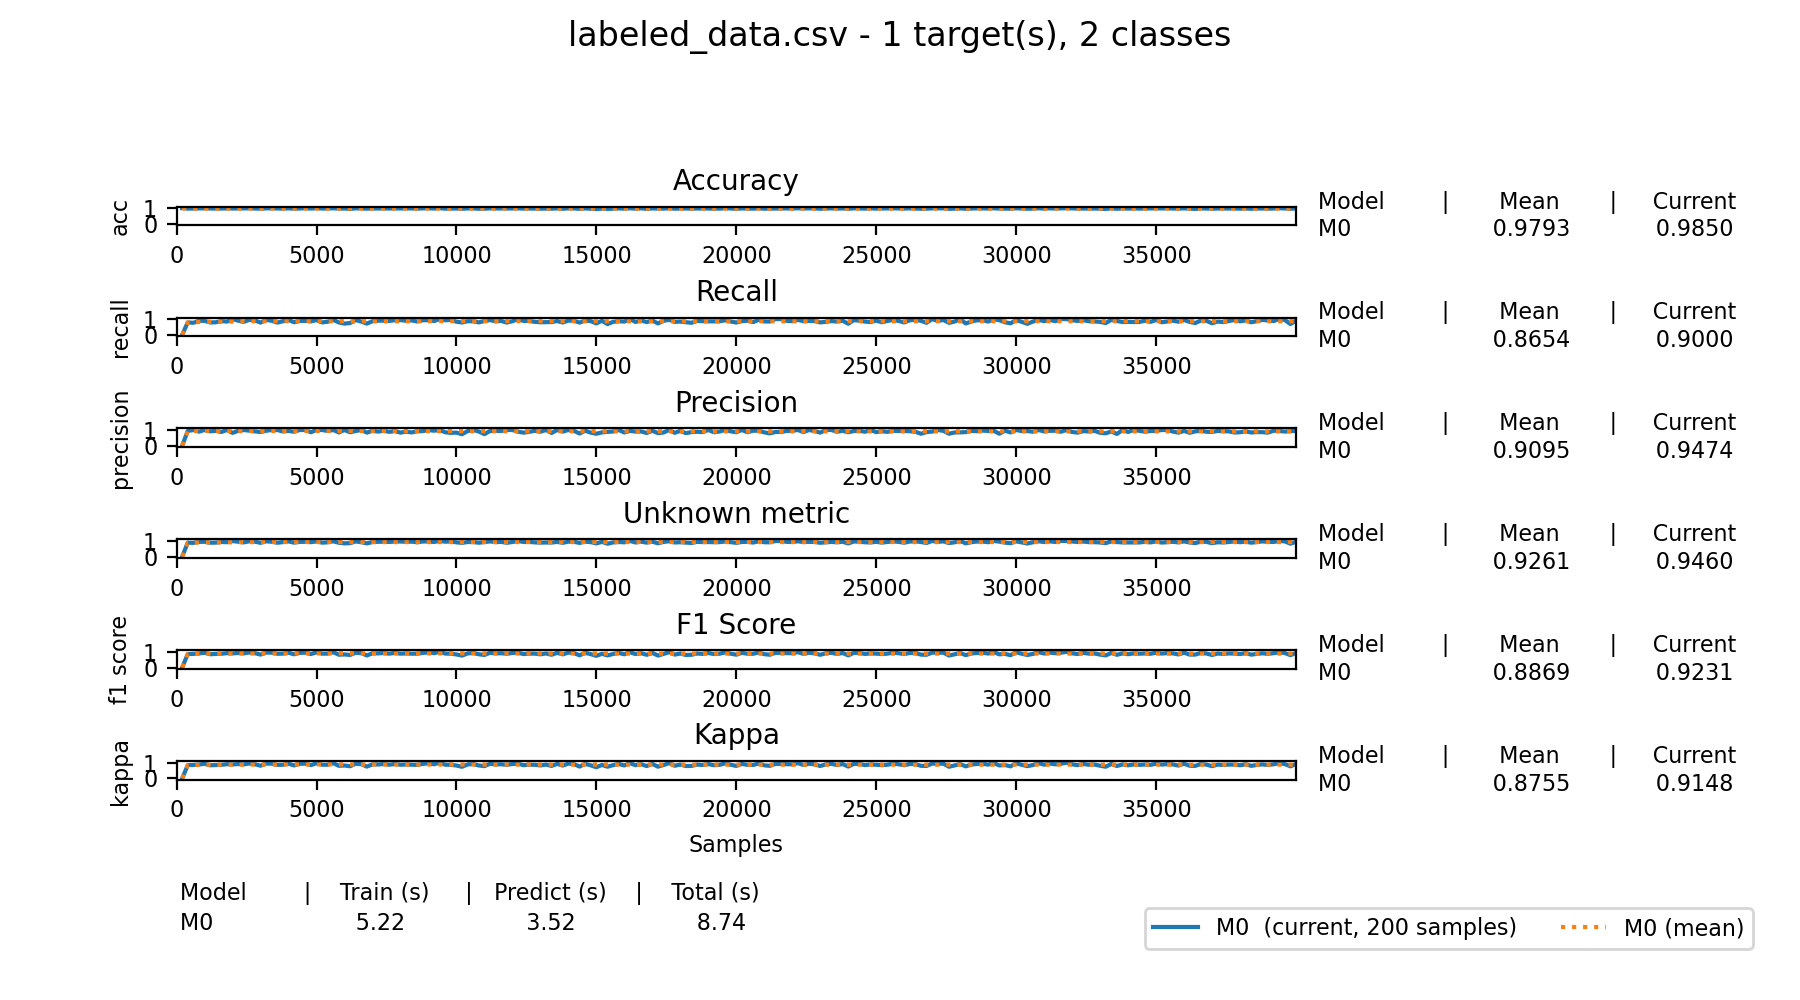

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [15.94s]
Processed samples: 40000
Mean performance:
M0 - Accuracy     : 0.9793
M0 - Kappa        : 0.8755
M0 - Precision: 0.9095
M0 - Recall: 0.8654
M0 - F1 score: 0.8869
M0 - Training time (s)  : 5.22
M0 - Testing time  (s)  : 3.52
M0 - Total time    (s)  : 8.74


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [53]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              data_points_for_classification=False,
                              max_samples=40000,
                             metrics=['accuracy', 'recall', 'precision','gmean' ,'f1', 'kappa', 'running_time'])
evaluator.evaluate(stream=st1, model=ht_sd)

#### Unlabeled

In [3]:
stream_unlab = FileStream('unlabeled_data.csv')

predictions_sd = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data.csv')))):
    X, Y = stream_unlab.next_sample()        # get the next sample
    y_pred = ht_sd.predict(X)       # predict Y using the tree     
    predictions.append(y_pred[0])   
    ht_sd.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:53<00:00, 3227.29it/s]


In [11]:
predictions_sd = pd.Series(predictions_sd, name='Labeled with subdomains')

### W/O subdom levels feature

In [54]:
# 1. Create a stream
st2 = FileStream('labeled_data_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht_nosd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 40000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st2.next_sample()        # get the next sample
    prediction = ht_nosd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_nosd.partial_fit(X, Y)             # update the tree

100%|██████████| 40000/40000 [00:09<00:00, 4144.22it/s]


#### Evalator

<IPython.core.display.Javascript object>


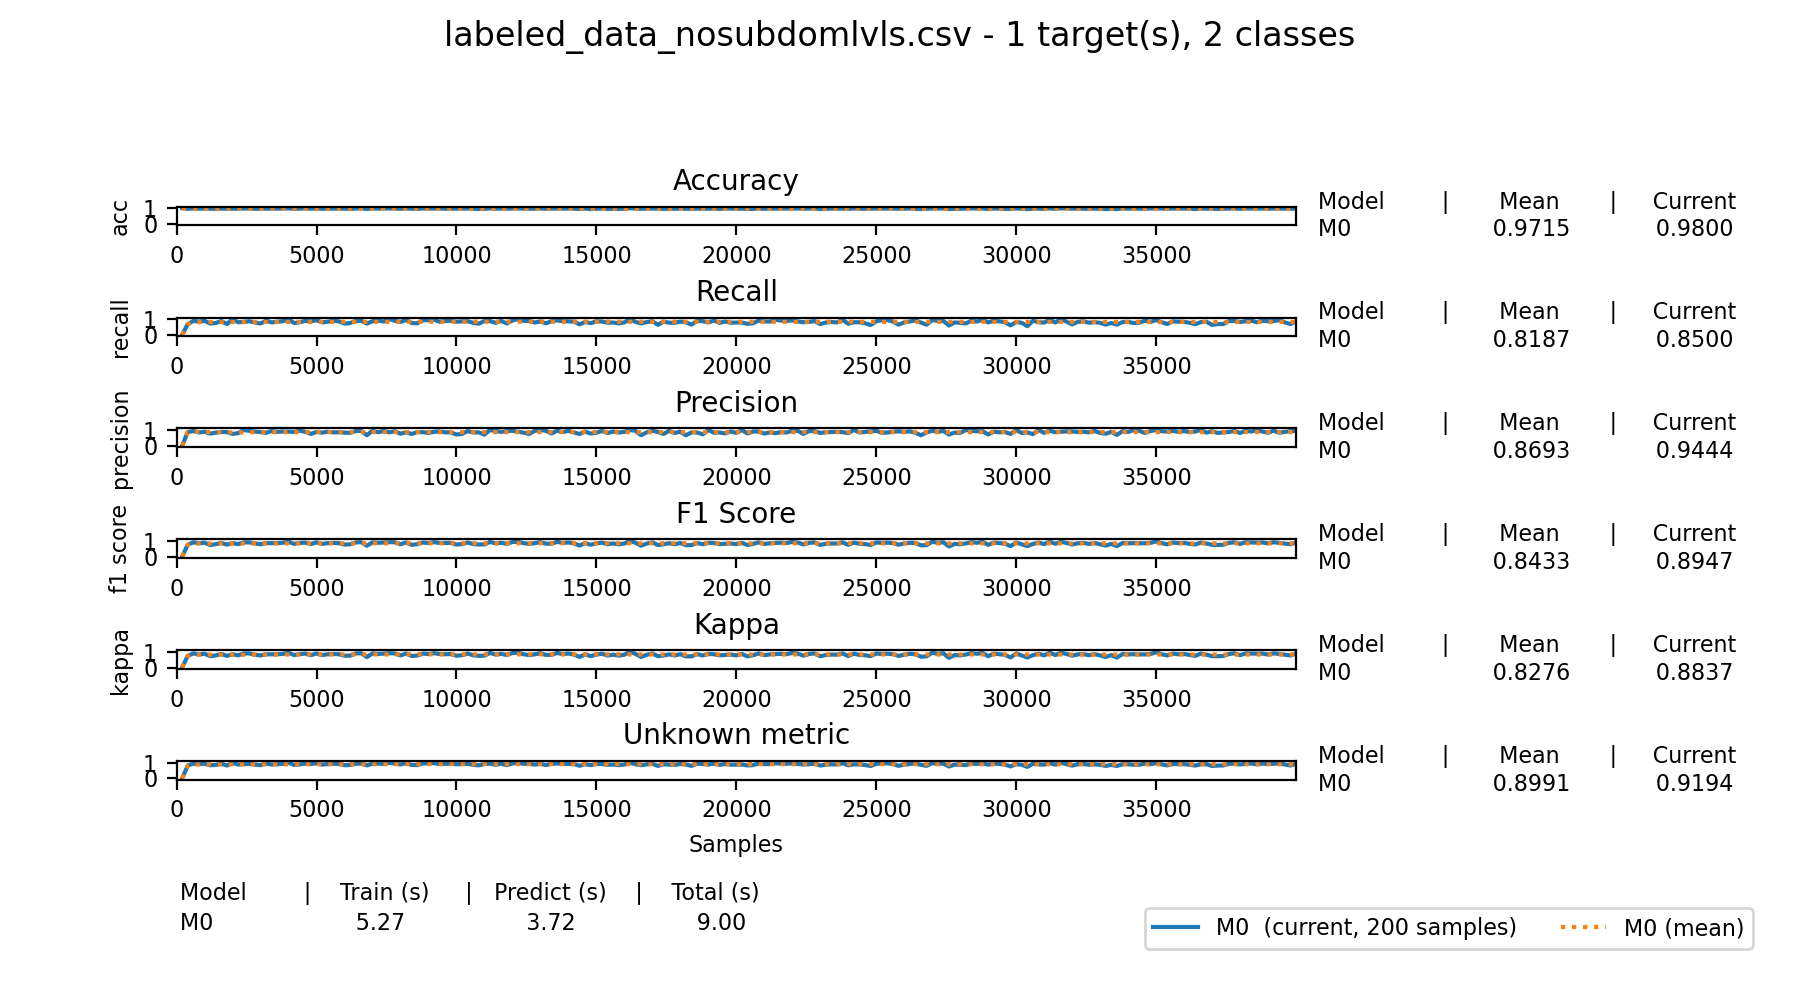

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [16.78s]
Processed samples: 40000
Mean performance:
M0 - Accuracy     : 0.9715
M0 - Kappa        : 0.8276
M0 - Precision: 0.8693
M0 - Recall: 0.8187
M0 - F1 score: 0.8433
M0 - Training time (s)  : 5.27
M0 - Testing time  (s)  : 3.72
M0 - Total time    (s)  : 9.00


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [56]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=40000,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st2, model=ht_nosd)

#### Unlabeled

In [12]:
stream_unlab_nosd = FileStream('unlabeled_data_nosubdomlvls.csv')

predictions_nosd = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data_nosubdomlvls.csv')))):
    X, Y = stream_unlab_nosd.next_sample()        # get the next sample
    y_pred = ht_nosd.predict(X)       # predict Y using the tree     
    predictions_nosd.append(y_pred[0])   
    ht_nosd.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:50<00:00, 3318.00it/s]


In [13]:
predictions_nosd = pd.Series(predictions_nosd, name='Labeled w/o subdomains')

In [14]:
ul = pd.read_csv('final_unlabeled.csv')['Domain']
df = pd.concat([pd.Series(ul, name='Domain'), predictions_sd, predictions_nosd], axis=1)

In [15]:
df.to_csv('unlabeled_predictions.csv', index=False, header=True)

## Imbalanced 25%

### W/ Subdom levels feature

In [58]:
# 1. Create a stream
st3 = FileStream('labeled_data_25.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht_25_sd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 19000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st3.next_sample()        # get the next sample
    prediction = ht_25_sd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_25_sd.partial_fit(X, Y)             # update the tree

100%|██████████| 19000/19000 [00:04<00:00, 4302.31it/s]


#### Evaluator

<IPython.core.display.Javascript object>


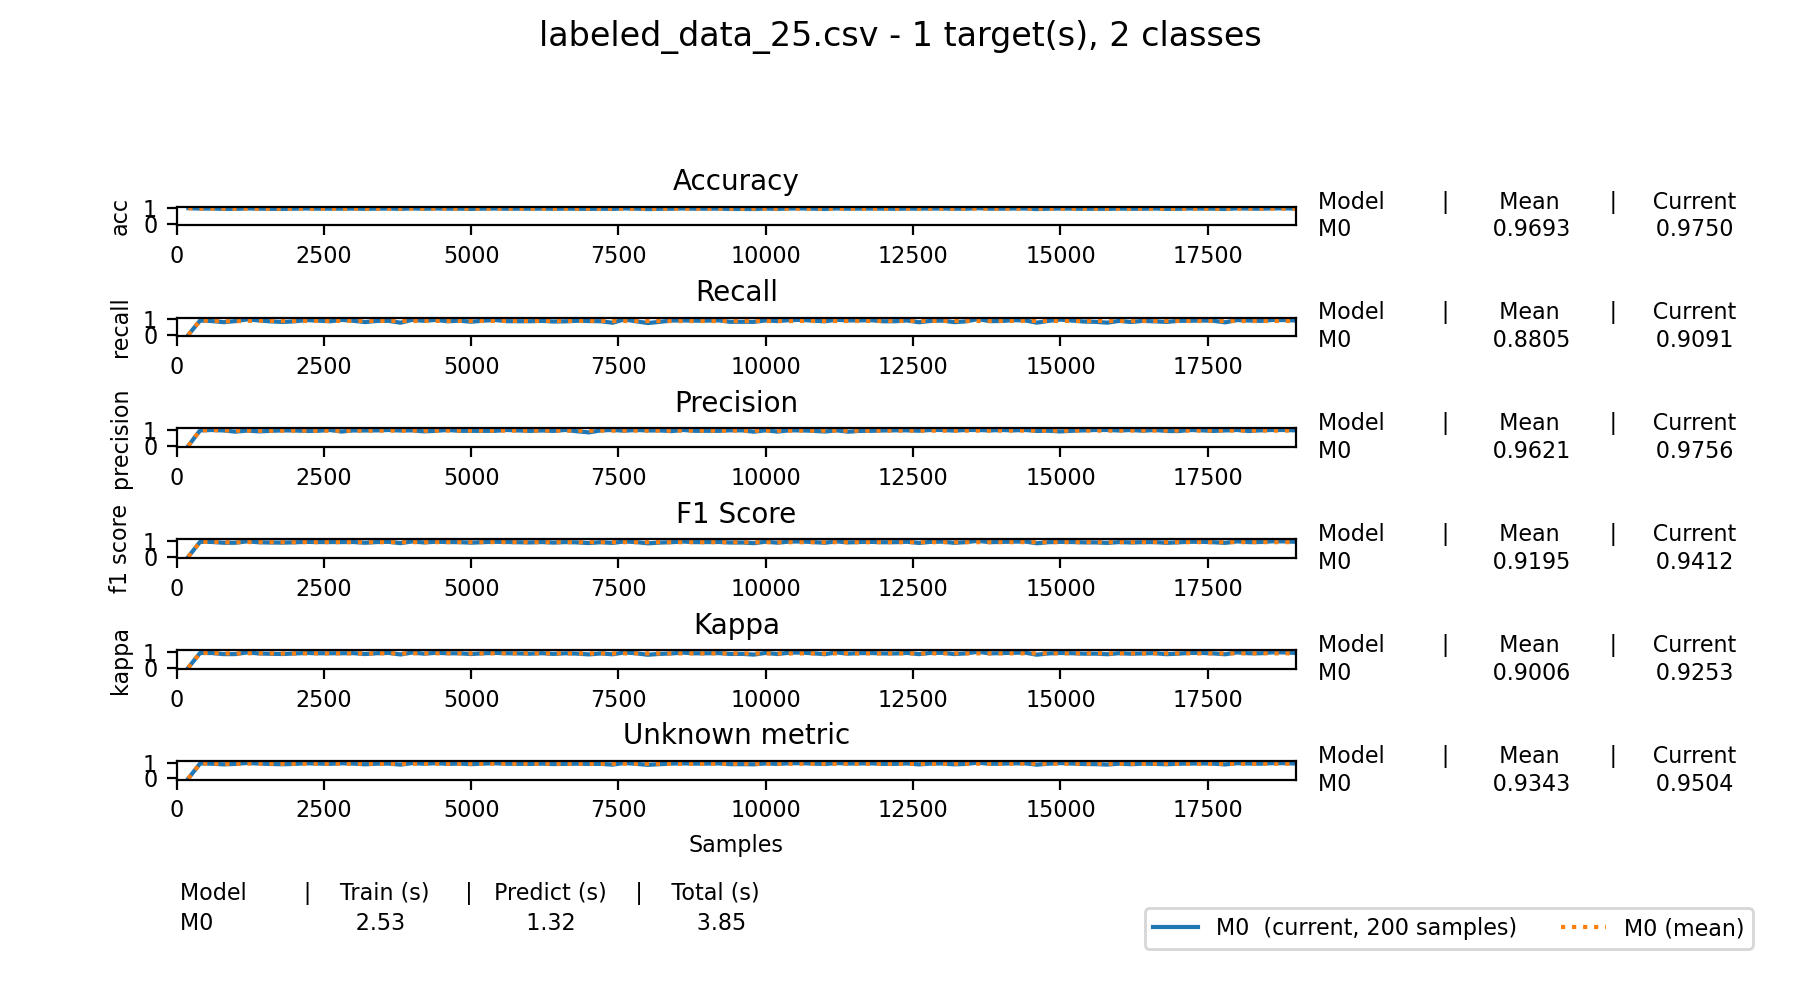

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [7.27s]
Processed samples: 19000
Mean performance:
M0 - Accuracy     : 0.9693
M0 - Kappa        : 0.9006
M0 - Precision: 0.9621
M0 - Recall: 0.8805
M0 - F1 score: 0.9195
M0 - Training time (s)  : 2.53
M0 - Testing time  (s)  : 1.32
M0 - Total time    (s)  : 3.85


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [60]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=19000,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st3, model=ht_25_sd)

### W/O subdom levels feature

In [61]:
# 1. Create a stream
st4 = FileStream('labeled_data_25_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht_25_nosd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 19000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st4.next_sample()        # get the next sample
    prediction = ht_25_nosd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_25_nosd.partial_fit(X, Y)             # update the tree

100%|██████████| 19000/19000 [00:05<00:00, 3771.42it/s]


#### Evalator

<IPython.core.display.Javascript object>


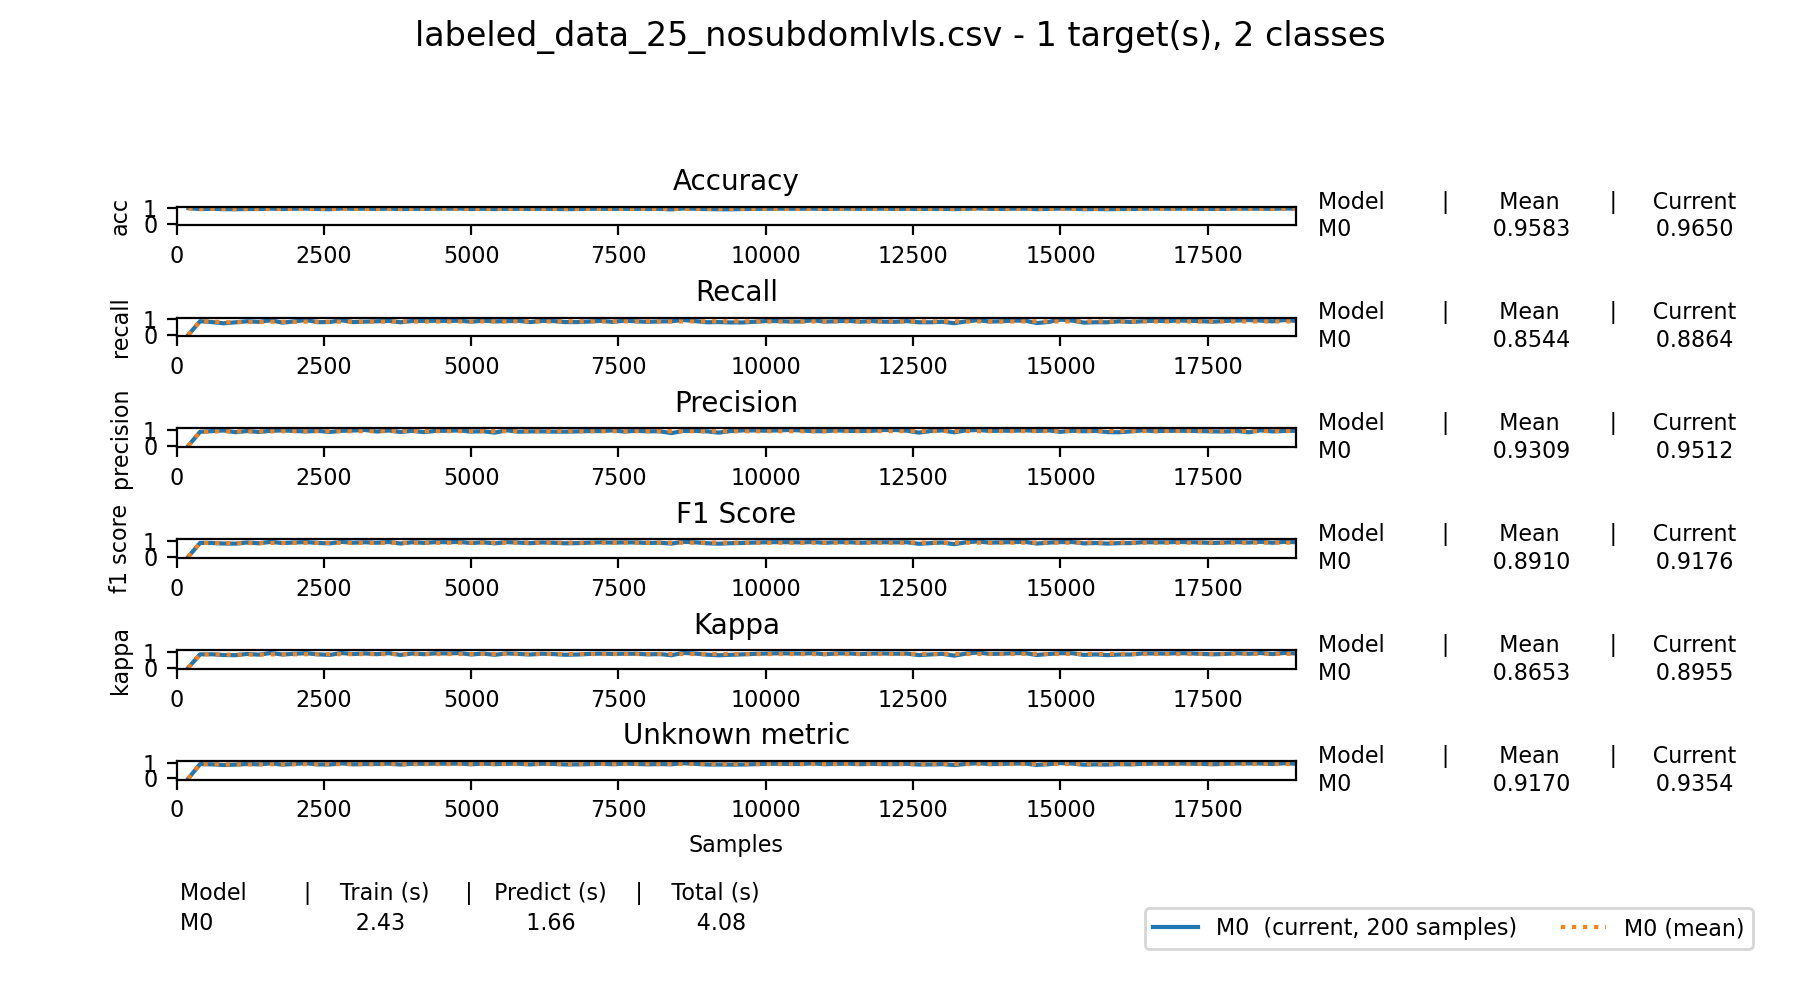

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [7.55s]
Processed samples: 19000
Mean performance:
M0 - Accuracy     : 0.9583
M0 - Kappa        : 0.8653
M0 - Precision: 0.9309
M0 - Recall: 0.8544
M0 - F1 score: 0.8910
M0 - Training time (s)  : 2.43
M0 - Testing time  (s)  : 1.66
M0 - Total time    (s)  : 4.08


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [63]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=19000,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st4, model=ht_25_nosd)

## Balanced data set

### W/ Subdom levels feature

In [68]:
# 1. Create a stream
st5 = FileStream('labeled_data_balanced.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht_50_sd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 7500

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st5.next_sample()        # get the next sample
    prediction = ht_50_sd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_50_sd.partial_fit(X, Y)             # update the tree

100%|██████████| 7500/7500 [00:01<00:00, 4545.45it/s]


In [52]:
correctness_dist.count(1)/len(correctness_dist)

0.9986

#### Evaluator

<IPython.core.display.Javascript object>


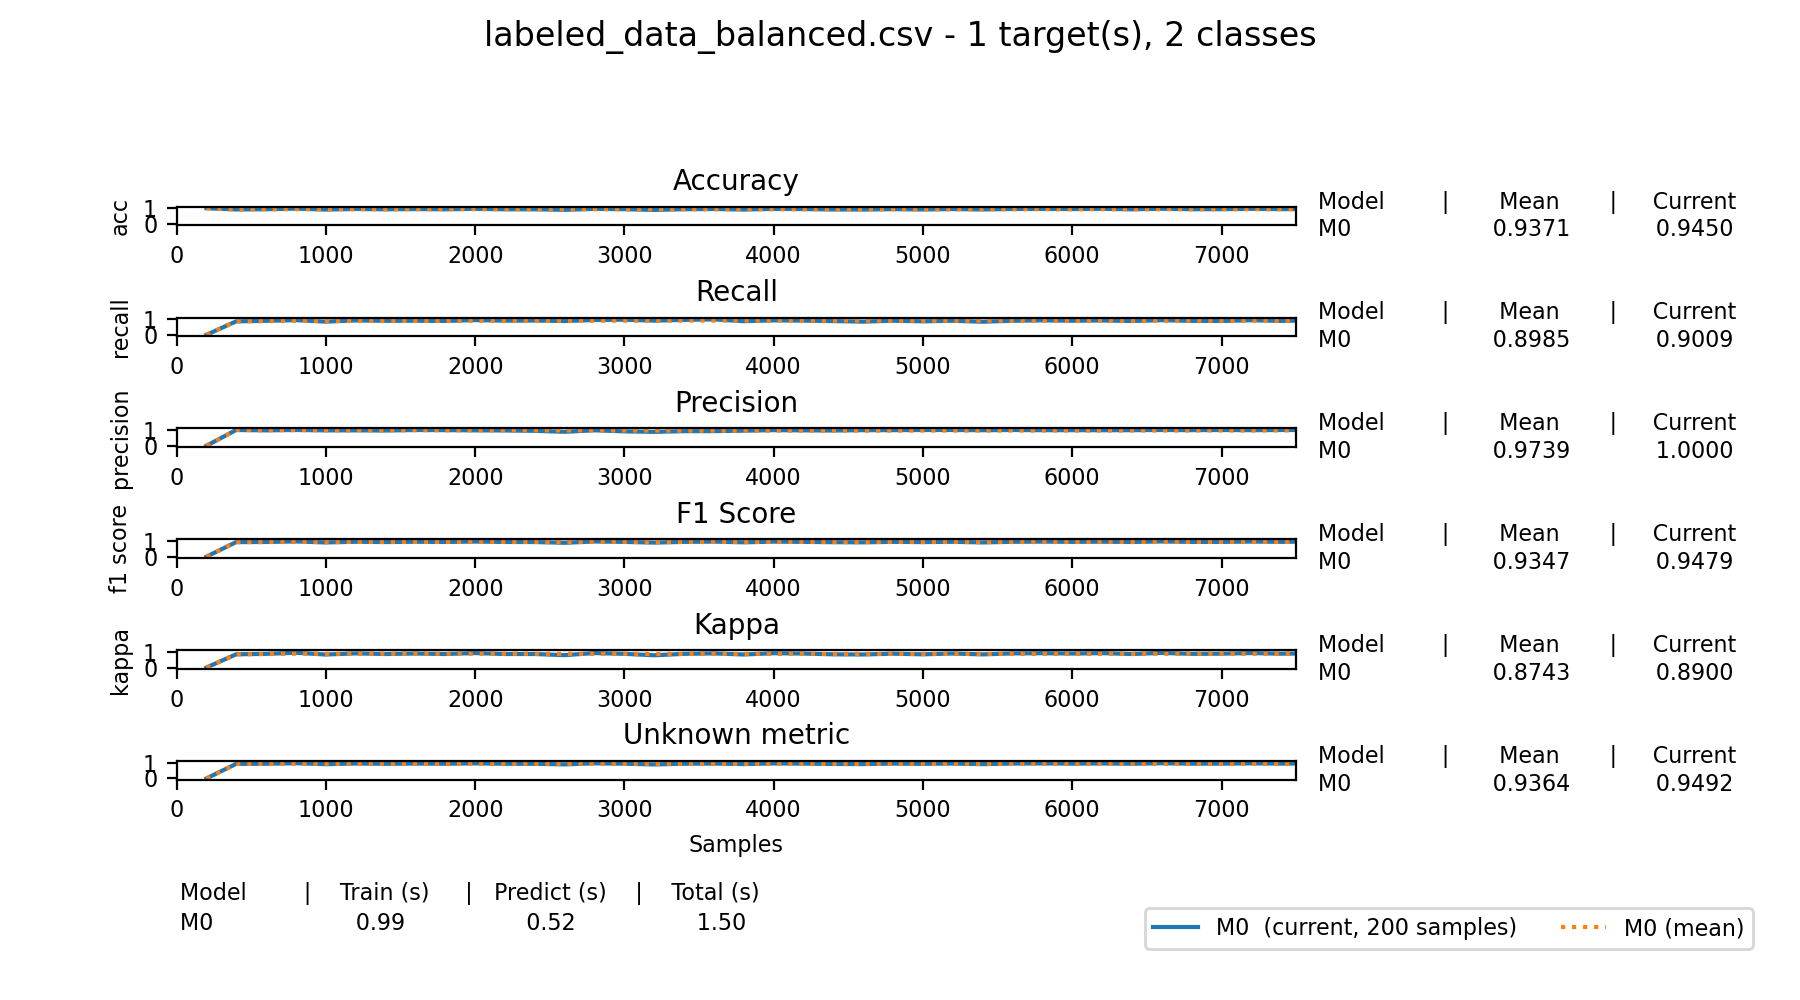

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [2.99s]
Processed samples: 7500
Mean performance:
M0 - Accuracy     : 0.9371
M0 - Kappa        : 0.8743
M0 - Precision: 0.9739
M0 - Recall: 0.8985
M0 - F1 score: 0.9347
M0 - Training time (s)  : 0.99
M0 - Testing time  (s)  : 0.52
M0 - Total time    (s)  : 1.50


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [70]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=7500,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st5, model=ht_50_sd)

### W/O subdom levels feature

In [72]:
# 1. Create a stream
st6 = FileStream('labeled_data_balanced_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht_50_nosd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 7500
getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st6.next_sample()        # get the next sample
    prediction = ht_50_nosd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_50_nosd.partial_fit(X, Y)             # update the tree

100%|██████████| 7500/7500 [00:02<00:00, 3236.90it/s]


#### Evaluator

<IPython.core.display.Javascript object>


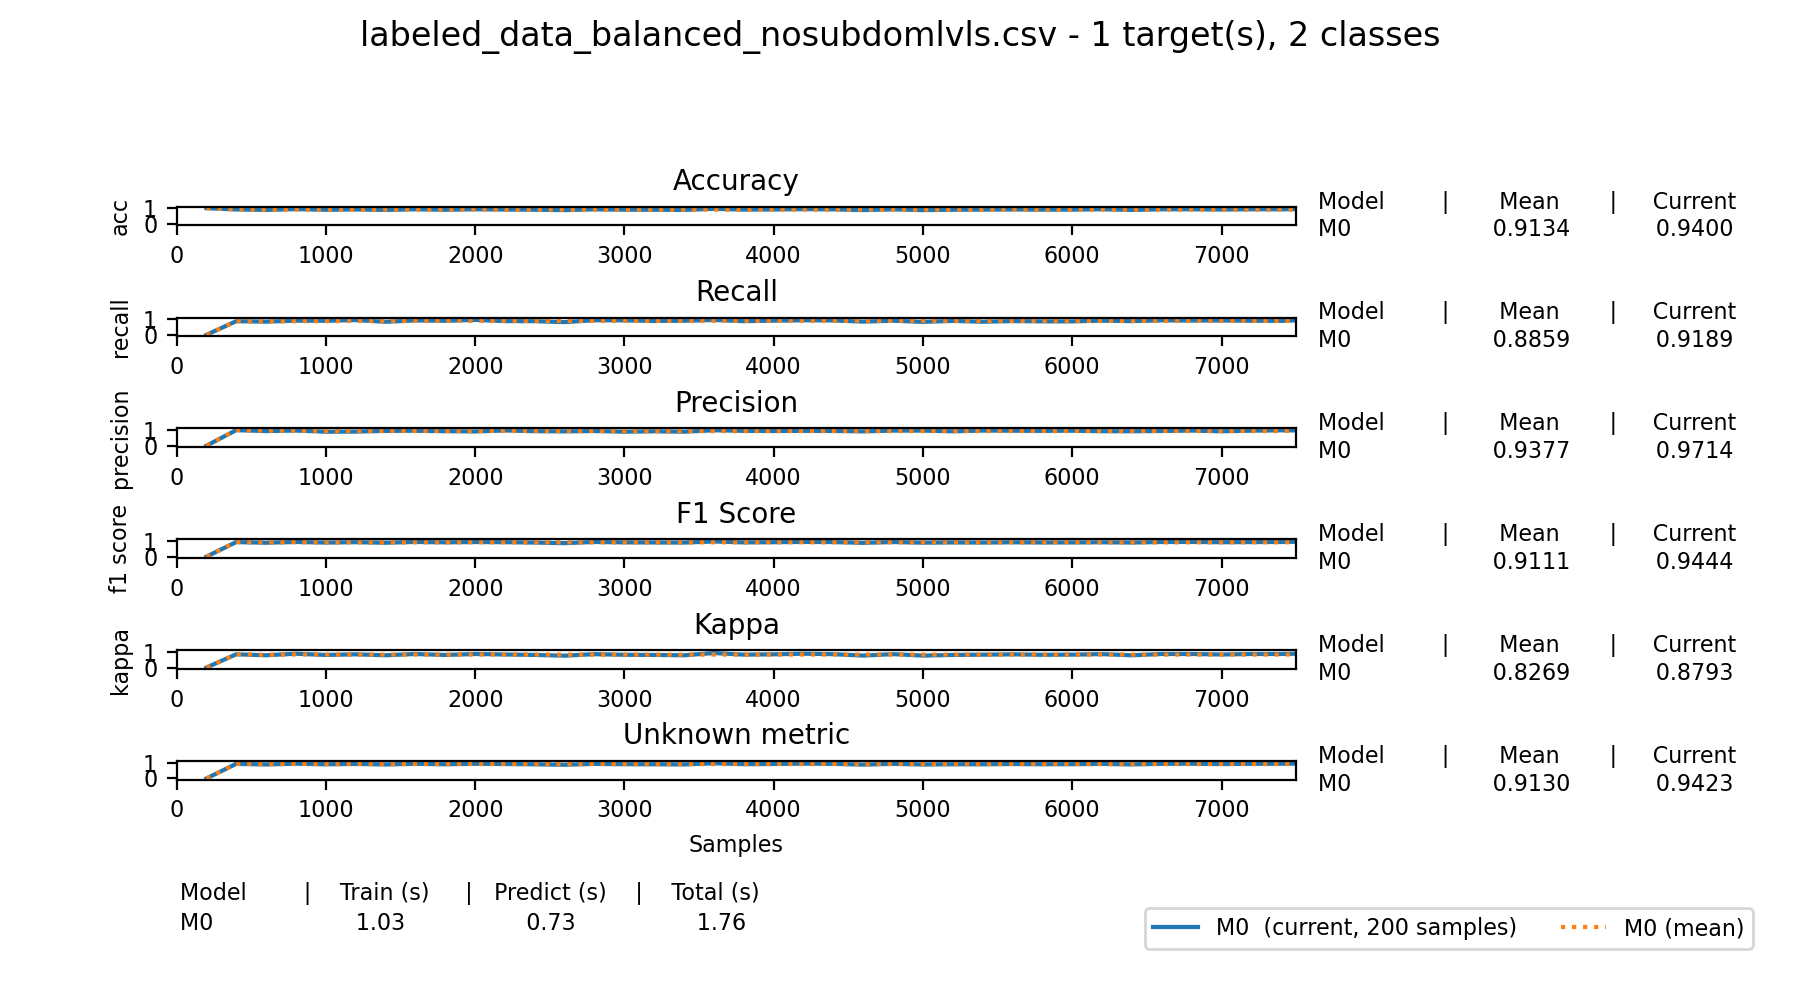

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [3.35s]
Processed samples: 7500
Mean performance:
M0 - Accuracy     : 0.9134
M0 - Kappa        : 0.8269
M0 - Precision: 0.9377
M0 - Recall: 0.8859
M0 - F1 score: 0.9111
M0 - Training time (s)  : 1.03
M0 - Testing time  (s)  : 0.73
M0 - Total time    (s)  : 1.76


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [74]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=7500,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st6, model=ht_50_nosd)